In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
# !pip install altair vega_datasets notebook vega
import altair as alt
alt.renderers.enable('kaggle')
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier
!pip install dtreeviz
from dtreeviz.trees import *
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



  Using cached dtreeviz-1.3.2-py3-none-any.whl
  Using cached colour-0.1.5-py2.py3-none-any.whl (23 kB)
  Using cached pytest-6.2.5-py3-none-any.whl (280 kB)
  Using cached iniconfig-1.1.1-py2.py3-none-any.whl (5.0 kB)
  Using cached py-1.11.0-py2.py3-none-any.whl (98 kB)


In this notebook, we try to understand how Decision Trees work on classification of the Spotify Attributes Dataset, how to determine features which are able to distinguish between classes, optimise the depth of the tree and visualise the optimised tree

### 1. Read Data

In [2]:
#passing index_col = 0 specifies that the first column in the data is the index, so just skip it 
spotify_df = pd.read_csv("../input/data.csv", index_col = 0)

### 2. Split Data

In [3]:

train_df, test_df = train_test_split(spotify_df, test_size=0.2, random_state=123)

### 3. EDA

In [4]:
train_df.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target,song_title,artist
1505,0.00477,0.585,214740,0.614,0.000155,10,0.0762,-5.594,0,0.0370,114.059,4.0,0.2730,0,Cool for the Summer,Demi Lovato
813,0.11400,0.665,216728,0.513,0.303000,0,0.1220,-7.314,1,0.3310,100.344,3.0,0.0373,1,Damn Son Where'd You Find This? (feat. Kelly H...,Markus Maximus
615,0.03020,0.798,216585,0.481,0.000000,7,0.1280,-10.488,1,0.3140,127.136,4.0,0.6400,1,Trill Hoe,Western Tink
319,0.10600,0.912,194040,0.317,0.000208,6,0.0723,-12.719,0,0.0378,99.346,4.0,0.9490,1,Who Is He (And What Is He to You?),Bill Withers
320,0.02110,0.697,236456,0.905,0.893000,6,0.1190,-7.787,0,0.0339,119.977,4.0,0.3110,1,Acamar,Frankey


We divide our data into training and test set in the ratio 80:20 respectively


In [5]:
train_df.shape, test_df.shape

((1613, 16), (404, 16))

Looking at `train_df.info()` gives us a rough idea about the features being numeric or textual and the number of `NaNs` in each feature

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1613 entries, 1505 to 1534
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   acousticness      1613 non-null   float64
 1   danceability      1613 non-null   float64
 2   duration_ms       1613 non-null   int64  
 3   energy            1613 non-null   float64
 4   instrumentalness  1613 non-null   float64
 5   key               1613 non-null   int64  
 6   liveness          1613 non-null   float64
 7   loudness          1613 non-null   float64
 8   mode              1613 non-null   int64  
 9   speechiness       1613 non-null   float64
 10  tempo             1613 non-null   float64
 11  time_signature    1613 non-null   float64
 12  valence           1613 non-null   float64
 13  target            1613 non-null   int64  
 14  song_title        1613 non-null   object 
 15  artist            1613 non-null   object 
dtypes: float64(10), int64(4), object(2)
mem

Luckily, we don't have any null values in our data, as we can see above

Let's view high level summary statistics of our data

In [7]:
train_df.describe()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target
count,1613.000000,1613.000000,1613.000000,1613.000000,1613.000000,1613.000000,1613.000000,1613.000000,1613.000000,1613.000000,1613.000000,1613.000000,1613.000000,1613.000000
mean,0.185627,0.616745,247114.827650,0.681296,0.136862,5.383137,0.189189,-7.112929,0.621203,0.091277,121.979777,3.964662,0.497587,0.507750
std,0.259324,0.163225,81177.300308,0.211612,0.277744,3.620422,0.153170,3.838867,0.485238,0.087890,26.965641,0.255201,0.247378,0.500095
min,0.000005,0.122000,16042.000000,0.014800,0.000000,0.000000,0.018800,-33.097000,0.000000,0.023100,47.859000,1.000000,0.035900,0.000000
25%,0.009190,0.511000,200105.000000,0.564000,0.000000,2.000000,0.092300,-8.388000,0.000000,0.037300,100.518000,4.000000,0.295000,0.000000
50%,0.062500,0.629000,230200.000000,0.714000,0.000071,6.000000,0.127000,-6.248000,1.000000,0.054900,121.990000,4.000000,0.496000,1.000000
75%,0.251000,0.738000,272533.000000,0.844000,0.057300,9.000000,0.243000,-4.791000,1.000000,0.107000,137.932000,4.000000,0.690000,1.000000
max,0.995000,0.984000,849960.000000,0.997000,0.976000,11.000000,0.969000,-0.307000,1.000000,0.816000,219.331000,5.000000,0.992000,1.000000


- Below, we visualise the distribution of each feature in our data. From the distributions we can find out which features are continuous, which are discrete, their skewness, modality, etc which helps us understand the data better
- Decision Trees use histograms under the hood for to identify the best features and thresholds that are able to distinguish between the classes


In [8]:
numeric_features = list(train_df.select_dtypes('number').columns)

In [9]:
# Let's plot each feature's distribution with respect to the predicted class

alt.Chart(train_df).mark_bar(opacity = 0.6).encode(
     alt.X(alt.repeat(), type='quantitative', bin=alt.Bin(maxbins=60)),
     y=alt.Y('count()', stack=False),
    color = 'target:N'
).properties(
    width=300,
    height=200
).repeat(
    numeric_features, columns = 3
) 

alt.RepeatChart(...)

#### Some Observations

- In the plot above, we observe that for the feature `energy`, the threshold can be considered as 0.2 as it is clearly visible that below 0.2 energy value, more people tend to dislike songs(indicated by blue bars and very less orange bars). Similarly, we can observe for the feature `loudness`, a reasonable threshold would be something around -5 approximately, we can predict that more users like songs when `loudness` > -5 and dislike songs with `loudness` < -5
- We can see bimodality for `tempo` when the user dislikes the songs(blue color bars), other features are mostly unimodal in nature

#### Relationship between features
- For finding out the relationship among features, we will use `Spearman Correlation`, instead of `Pearson`, as `Spearman correlation` helps in finding non-linear relationships as well

In [10]:
corr_df = train_df.corr('spearman').stack().reset_index(name='corr')
corr_df.loc[corr_df['corr'] == 1, 'corr'] = 0  # Remove diagonal
corr_df['abs'] = corr_df['corr'].abs()
corr_df

,level_0,level_1,corr,abs
0,acousticness,acousticness,0.000000,0.000000
1,acousticness,danceability,-0.008554,0.008554
2,acousticness,duration_ms,-0.021230,0.021230
3,acousticness,energy,-0.502339,0.502339
4,acousticness,instrumentalness,-0.128552,0.128552
...,...,...,...,...
191,target,speechiness,0.145017,0.145017
192,target,tempo,0.046800,0.046800
193,target,time_signature,0.030498,0.030498
194,target,valence,0.117993,0.117993


In [11]:
alt.Chart(corr_df).mark_circle().encode(
    x='level_0',
    y='level_1',
    size='abs',
    color=alt.Color('corr', scale=alt.Scale(scheme='blueorange', domain=(-1, 1))))

alt.Chart(...)

#### Some Observations
- We can see that there is no strong relation of any feature with our `target` feature
- But, there is a positive correlation between `energy` and `loudness`, which seems quite reasonable and we have a negative correlation between acousticness and energy, which also makes sense, as music which is more acoustic tends to be a soft melody with less energy and misuc with high energy have less acousticness in it, but more loudness

### 4. Model Building

For simplicity, let's remove the text features from the data and just understand decision trees using numeirc features for now, as textual features need some preprocessing 

In [12]:
X_train,y_train = train_df.drop(columns=["song_title", "artist", "target"]), train_df['target']
X_test, y_test = test_df.drop(columns=["song_title", "artist", "target"]), test_df['target']


In [13]:
model = DecisionTreeClassifier()
model_scores = pd.DataFrame(cross_validate(model, X_train, y_train, cv=10, return_train_score=True))
model_scores

,fit_time,score_time,test_score,train_score
0,0.022548,0.001970,0.734568,0.999311
1,0.013965,0.001437,0.641975,1.000000
2,0.013192,0.001172,0.672840,0.999311
3,0.012747,0.000814,0.701863,1.000000
4,0.009992,0.000724,0.670807,0.999311
5,0.010025,0.000712,0.633540,0.999311
6,0.009759,0.000715,0.670807,0.999311
7,0.010987,0.000837,0.621118,0.999311
8,0.010482,0.000770,0.695652,0.999311
9,0.010136,0.000709,0.701863,0.999311


In [14]:
round(np.mean(model_scores['test_score']),3), round(np.mean(model_scores['train_score']),3)

(0.675, 0.999)

#### Some Observations
- We can see a lot of variance in the validation score from 0.61 to 0.73, so we looked at the mean value of the validation score, which is 0.676 and the mean of training score is 0.99. There is a lot of gap between the validation score and training score, which means our model is overfitting on the training data and also the training error is almost negligible, thus it is highly overfitting the data
- So, let's try to prune the tree a but by changing the depth of the tree and try to optimise it

### 5. Optimise Depth of Tree 


Let's try to see the validation and traininig scores for depths 1 to 25

In [15]:
results_dict = {
    "max_depth": [],
    "mean_train_score": [],
    "mean_cv_score": []
}

for depth in range(1, 26):
    model = DecisionTreeClassifier(max_depth=depth)
    cv_score = cross_validate(model, X_train, y_train, cv=10, return_train_score=True)
    results_dict["max_depth"].append(depth)
    results_dict["mean_cv_score"].append( np.mean(cv_score["test_score"]))
    results_dict["mean_train_score"].append( np.mean(cv_score["train_score"]))

    
result_df = pd.DataFrame(results_dict)
result_df



,max_depth,mean_train_score,mean_cv_score
0,1,0.650686,0.642926
1,2,0.711718,0.692520
2,3,0.732797,0.693766
3,4,0.768066,0.724757
4,5,0.793346,0.712334
5,6,0.826893,0.714201
6,7,0.862300,0.703037
7,8,0.892265,0.697443
8,9,0.917201,0.689372
9,10,0.939106,0.687520


In [16]:
results = pd.melt(result_df, id_vars=['max_depth'], value_vars=['mean_train_score', 'mean_cv_score'])
results.head(4)

,max_depth,variable,value
0,1,mean_train_score,0.650686
1,2,mean_train_score,0.711718
2,3,mean_train_score,0.732797
3,4,mean_train_score,0.768066


Let's plot a graph to see how the scores change with depth

In [17]:
alt.Chart(results).mark_line().encode(
    x=alt.X('max_depth', title= 'Depth of tree'),
    y= alt.Y('value',title = 'Score', scale=alt.Scale(zero=False)),
    color=alt.Color('variable', title='Score type')
)

alt.Chart(...)

#### Select the best max_depth of the tree
Above, we can see that the training score keeps increasing and gets stabilised when `max_depth` = 25, while the validation increases to a point and then starts decreasing. So, the best depth for the tree would be 4 as at `max_depth`=4, the vaidation score is highest

### 6. Model with best depth
Now, we will observe the scores with our best `max_depth` and ideally, it should now decrease the overfitting

In [18]:
optimised_model = DecisionTreeClassifier(max_depth=4)
optimised_scores = pd.DataFrame(cross_validate(optimised_model, X_train, y_train, cv =10, return_train_score = True))



In [19]:
optimised_scores

,fit_time,score_time,test_score,train_score
0,0.005893,0.001184,0.746914,0.768436
1,0.005281,0.001165,0.703704,0.778773
2,0.005392,0.001103,0.685185,0.772571
3,0.005289,0.000760,0.739130,0.763085
4,0.005054,0.000877,0.714286,0.769972
5,0.004904,0.000805,0.726708,0.761708
6,0.004761,0.000698,0.714286,0.771350
7,0.004775,0.000694,0.714286,0.761708
8,0.004686,0.000677,0.708075,0.771350
9,0.004698,0.000678,0.788820,0.761708


#### Some Observations
- We can see that the training score has now reduced from 0.99 to around 0.75
- Let's see how our model did the splitting on features with `max_depth`=4

/Users/navyadahiya/opt/miniconda3/envs/571/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


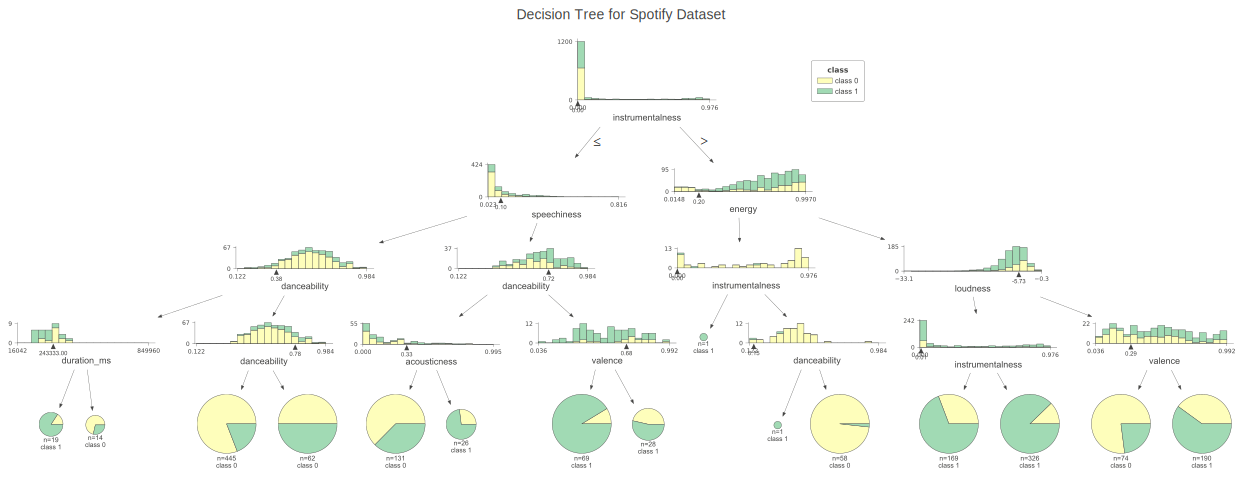

In [20]:
!pip install dtreeviz
# !pip install --no-cache graphviz


optimised_model.fit(X_train, y_train)
dt_viz = dtreeviz(optimised_model, 
               x_data=X_train,
               y_data=y_train,
               target_name='class',
               feature_names=X_train.columns, 
               title="Decision Tree for Spotify Dataset")
dt_viz

### 7. Model evaluation on Test set


In [21]:
optimised_model = DecisionTreeClassifier(max_depth=4)
optimised_model.fit(X_train, y_train)

print(f"Score for test data: {round(optimised_model.score(X_test, y_test), 3)}")

Score for test data: 0.678


From the `optimised_scores` table above, we can see that the `validation score` is 0.714286 and the score on `test data` is 0.676, which provides us an estimate of how well our model will generalise on the deployment data